## Library

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

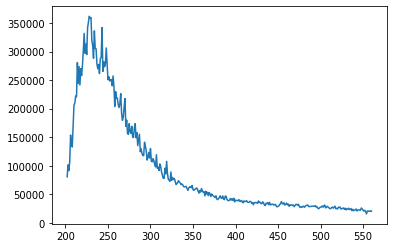

In [302]:
training_set = pd.read_csv('Wordle.csv')

training_set_x = training_set.loc[:, ['Contest number']].values
training_set_y = training_set.loc[:, ['Number of  reported results']].values

training_set = training_set.loc[:, ['Number of  reported results']].values

plt.plot(training_set_x, training_set_y, label='Wordle Data')
plt.show()

## Dataloading

In [303]:
data = training_set_y
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.18788869],
       [0.24815362],
       [0.21920636],
       [0.26441156],
       [0.39937752],
       [0.35233316],
       [0.33830128],
       [0.44442969],
       [0.54951293],
       [0.56027937],
       [0.59662369],
       [0.59302332],
       [0.76530948],
       [0.65946979],
       [0.7454021 ],
       [0.65232392],
       [0.73443644],
       [0.70010452],
       [0.75313119],
       [0.82803721],
       [0.91319863],
       [0.81250397],
       [0.85942706],
       [0.80591822],
       [0.9405406 ],
       [0.97042044],
       [1.        ],
       [0.9892249 ],
       [0.99356439],
       [0.87813047],
       [0.8530694 ],
       [0.78726967],
       [0.9258793 ],
       [0.83676816],
       [0.83520329],
       [0.76012403],
       [0.73430941],
       [0.75621185],
       [0.7101607 ],
       [0.78613788],
       [0.79158029],
       [0.9425299 ],
       [0.7208925 ],
       [0.77023219],
       [0.74418658],
       [0.75984975],
       [0.83960919],
       [0.756

## Model

In [304]:
inp_dim = 1
out_dim = 1
mid_dim = 10
mid_layers = 2
batch_size = 200
mod_dir = '.'

data_x = data[:-1, :]
data_y = data[+1:, 0]

train_size = int(len(data_x) * 0.75)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

In [305]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [306]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [307]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [308]:
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence

batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [309]:
print("Training Start")
net = net.train()
for e in range(1000):
    out = net(batch_var_x)

    loss = criterion(out, batch_var_y)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {}'.format(e, loss.item()))
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 0.10748413950204849
Epoch:   64, Loss: 0.003648881334811449
Epoch:  128, Loss: 0.0005890345782972872
Epoch:  192, Loss: 0.00015102098404895514
Epoch:  256, Loss: 0.0001117673673434183
Epoch:  320, Loss: 9.253983444068581e-05
Epoch:  384, Loss: 8.257491572294384e-05
Epoch:  448, Loss: 7.662977441214025e-05
Epoch:  512, Loss: 7.170935714384541e-05
Epoch:  576, Loss: 6.860657595098019e-05
Epoch:  640, Loss: 6.478519208030775e-05
Epoch:  704, Loss: 7.76786109781824e-05
Epoch:  768, Loss: 6.169307016534731e-05
Epoch:  832, Loss: 5.9816484281327575e-05
Epoch:  896, Loss: 5.8619159972295165e-05
Epoch:  960, Loss: 5.9606682043522596e-05
Save in: ./net.pth


In [310]:
'''eval'''
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.copy()
test_x[train_size:, 0] = 0
zeros = np.zeros((60, 1))
test_x = np.append(test_x, zeros)
test_x = test_x.reshape(len(test_x), 1, 1)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
for i in range(train_size, len(test_x)):
    tmp_y = net(test_x[:i])
    test_x[i, 0, 0] = tmp_y[-1]

## Training

## Testing for Wordle Hard Mode Player Dataset

In [311]:
pred_y = test_x[0:, 0, 0]
pred_y = pred_y.cpu().data.numpy().reshape(len(pred_y), 1)
pred_y = scaler.inverse_transform(pred_y)
pred_y = np.round(pred_y)
pred_y

array([[ 80630.],
       [101503.],
       [ 91477.],
       [107134.],
       [153880.],
       [137586.],
       [132726.],
       [169484.],
       [205880.],
       [209609.],
       [222197.],
       [220950.],
       [280622.],
       [243964.],
       [273727.],
       [241489.],
       [269929.],
       [258038.],
       [276404.],
       [302348.],
       [331844.],
       [296968.],
       [313220.],
       [294687.],
       [341314.],
       [351663.],
       [361908.],
       [358176.],
       [359679.],
       [319698.],
       [311018.],
       [288228.],
       [336236.],
       [305372.],
       [304830.],
       [278826.],
       [269885.],
       [277471.],
       [261521.],
       [287836.],
       [289721.],
       [342003.],
       [265238.],
       [282327.],
       [273306.],
       [278731.],
       [306356.],
       [277576.],
       [250674.],
       [255907.],
       [248363.],
       [250413.],
       [251094.],
       [240137.],
       [257304.],
       [24

In [312]:
test_pred_y = pred_y[train_size: len(training_set_y)]
future_pred = pred_y[len(training_set_y):]

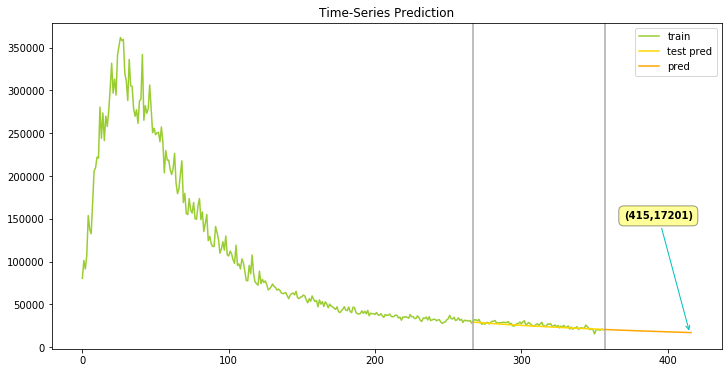

In [313]:
plt.figure(figsize=(12, 6))
plt.plot(training_set_y, color="yellowgreen", label="train")
plt.plot(np.linspace(train_size, len(training_set_y), num=len(training_set_y) - train_size), test_pred_y, color="gold",
         label="test pred")
plt.plot(np.linspace(len(training_set_y), len(pred_y), num=len(pred_y) - len(training_set_y)), future_pred,
         color="orange", label="pred")
plt.axvline(train_size, color='darkgrey')
plt.axvline(len(training_set_y), color='darkgrey')
plt.title('Time-Series Prediction')
plt.legend()
plt.annotate(s='(415,17201)', xy=(415, 17201), xytext=(370, 150000), weight='bold',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='c'),
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.4))
plt.show()

In [315]:
from sklearn.metrics import r2_score
print(r2_score(training_set_y[train_size: ], test_pred_y))

0.6054932547341563
